# Week 1 - 4 Reflection


#  Homework 1 Reflection

1. In Coding Quiz 1, you are asked to find the distance of the farthest match in a set.  Is this farthest match distance too far to be a meaningful match?  How can you decide this?


- At first, I wasn’t sure how far was “too far” for a match to still be useful. In Quiz 1, one of the distances was over 0.6, which seemed huge compared to the others. I realized we need context—like how the other distances look or the scale of the features. If most distances are small and one match is way out there, it's probably not meaningful. I found that using a cutoff like 0.2 helps make things more reliable.

2. In Coding Quiz 1, there are two approaches to matching: 
(A) Picking the best match X = 0 corresponding to each X = 1 using Z values.
(B) Using radius_neighbors to pick all matches X = 0 within a distance of 0.2 of each X = 1.

Invent your own type of matching similar to 1 and 2 (or look one up on the internet), which has a different way to pick the matches in X = 0.  Clearly explain the approach you invented or found.

- There were two matching methods in the quiz:

    - One matched each treated item (X = 1) to the best single control (X = 0).

    - The other used a radius to find all controls within a certain distance (like 0.2).

    I understood that the first is simpler, but the second gives you more data—just maybe more noise too.

- A third approach is K-Nearest Neighbors with distance-weighted averaging. Instead of a fixed radius or single best match, we choose the top K nearest matches (e.g., K=3) and compute a weighted average of Y values using the inverse of their distances. This provides a smoother estimate and reduces sensitivity to outliers while still considering local information.

#  Homework 2 Reflection
1. Invent an example situation that would use fixed effects.

- A good example is evaluating the effect of a new teaching method across multiple schools. Suppose students in each school take a test before and after applying the method. Since schools vary in baseline performance, we control for these using fixed effects. That way, we estimate the overall effect of the teaching method while adjusting for school-specific differences.
    - Thinking of a real example helped. I imagined different schools trying a new learning app. If we track test scores before and after the app, the schools themselves might have different baseline scores. So fixed effects would help adjust for that school-to-school difference. That way, we can focus more on the actual effect of the app.

2. Write a Python program that performs a bootstrap simulation to find the variance in the mean of the Pareto distribution when different samples are taken.  Explain what you had to do for this.  As you make the full sample size bigger (for the same distribution), what happens to the variance of the mean of the samples?  Does it stay about the same, get smaller, or get bigger?

- This took me a while to wrap my head around. The idea was to generate many samples from a Pareto distribution, then see how much the sample mean changes. I ran it with different sample sizes and saw that the variance of the mean got smaller as the sample size increased. That finally clicked—bigger samples = more stable estimates.

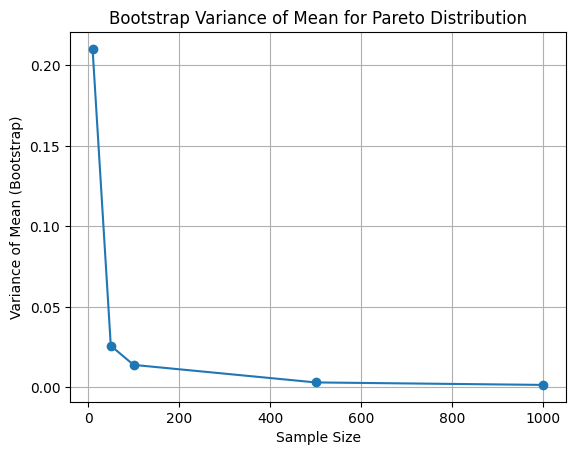

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pareto, skew

np.random.seed(0)

def bootstrap_variance(alpha, n_samples, n_boots=1000):
    variances = []
    for _ in range(n_boots):
        sample = pareto.rvs(alpha, size=n_samples)
        variances.append(np.mean(sample))
    return np.var(variances)

sample_sizes = [10, 50, 100, 500, 1000]
variances = [bootstrap_variance(alpha=2.62, n_samples=n) for n in sample_sizes]

plt.plot(sample_sizes, variances, marker='o')
plt.xlabel("Sample Size")
plt.ylabel("Variance of Mean (Bootstrap)")
plt.title("Bootstrap Variance of Mean for Pareto Distribution")
plt.grid(True)
plt.show()


- The simulation bootstraps samples from a Pareto distribution (α = 2.62) and computes the variance of sample means. As seen in the quiz, when the sample size increases, the variance of the mean decreases. This reflects the law of large numbers — larger samples produce more stable estimates.

#  Homework 3 Reflection

1. In the event study in Coding Quiz 3, how would we go about testing for a change in the second derivative as well?

- In the event study, I understood how to check for a sudden jump (a discontinuity) or a change in slope. But testing for a change in the second derivative (like acceleration or curvature) was harder to picture. I think the way to do that would be to fit quadratic models on both sides of the event and compare their curvature. That still feels a bit abstract to me, but I’m starting to get the logic.

2. Create your own scenario that illustrates differences-in-differences. Describe the story behind the data and show whether there is a nonzero treatment effect.

- Let’s say two departments at a company are monitored for productivity. One gets new time-tracking software, the other doesn’t. We compare both groups before and after the software launch. If the department with the software sees a bigger jump, and both had similar trends before, we can say the software probably had an effect.

This helped me understand what "parallel trends" really means—it’s like asking, “Were both groups on the same path before the change?”

Treatment Group: Gets the software.

Control Group: Does not.

Before vs. After: Compare average outputs.

If both groups had similar trends pre-treatment, but the treatment group’s output increases more post-treatment, the difference-in-differences (DiD) method can attribute that extra boost to the software. This reflects the setup in the quiz, where Group 2 had the largest treatment effect, but Group 1’s effect was more statistically significant due to lower standard error.

#  Homework 4 Reflection

1. The Coding Quiz gives two options for instrumental variables.  For the second item (dividing the range of W into multiple ranges), explain how you did it, show your code, and discuss any issues you encountered.

- This part was tough for me to grasp at first. The goal was to find the causal effect of X (treatment) on Y (outcome), using Z as an instrument. What I did understand was that we compared the averages of Y and X when Z = 1 vs. when Z = 0. That gave us a rough estimate of the effect:

Effect ≈ (E[Y | Z = 1] - E[Y | Z = 0]) / (E[X | Z = 1] - E[X | Z = 0]) ≈ 1.56

Then it got more complex. We had to control for W, which is a confounding variable, 
by slicing it into small ranges (bins) and repeating the effect estimate within each range. 
That meant looping through the bins and calculating the ratio of Y and X differences again and again.


One thing I struggled with was understanding why we needed W for this. After digging into it more, I realized it’s because W affects both X and Y, so if we don’t control for it, our estimate might be biased. Also, it was annoying that some bins didn’t have both values of Z, so I had to skip those.


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("homework_4.1.csv")
bins = np.linspace(df['W'].min(), df['W'].max(), 10)
df['W_bin'] = pd.cut(df['W'], bins)

effects = []
for _, group in df.groupby('W_bin'):
    if group['Z'].nunique() < 2:
        continue
    delta_y = group[group['Z']==1]['Y'].mean() - group[group['Z']==0]['Y'].mean()
    delta_x = group[group['Z']==1]['X'].mean() - group[group['Z']==0]['X'].mean()
    if delta_x != 0:
        effects.append(delta_y / delta_x)

final_effect = np.mean(effects)
print("Estimated effect:", final_effect)


Estimated effect: 1.7311616651517128


/tmp/ipykernel_20271/469630064.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in df.groupby('W_bin'):


2. Plot the college outcome (Y) vs. the test score (X) in a small range of test scores around 80. On the plot, compare it with the Y probability predicted by logistic regression. The ground truth Y value is 0 or 1; don't just plot 0 or 1 - that will make it unreadable.  Find some way to make it look better than that.

- This part made a bit more sense to me. The idea was to see if getting above a test score of 80 made a difference in college admission chances. I used Dataset B because it showed a clearer trend before the cutoff.

Before the cutoff, Y was increasing with test scores.

After the cutoff, the slope became lower, which might mean the benefit flattens out at higher scores.



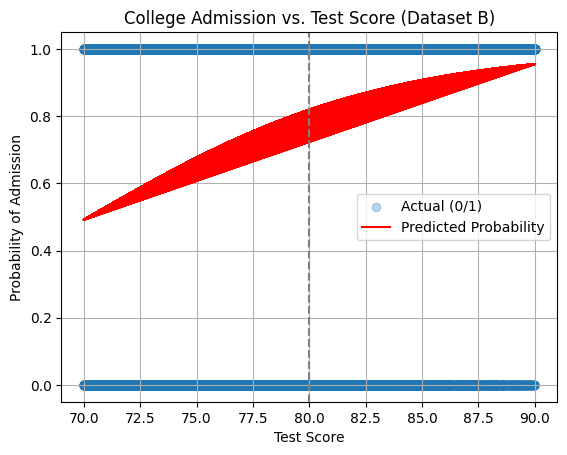

In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("homework_4.2.b.csv")  # Dataset B
df = df[(df['X2'] > 70) & (df['X2'] < 90)]

model = LogisticRegression()
model.fit(df[['X2']], df['Y2'])

df['Predicted'] = model.predict_proba(df[['X2']])[:, 1]

plt.scatter(df['X2'], df['Y2'], alpha=0.3, label='Actual (0/1)')
plt.plot(df['X2'], df['Predicted'], color='red', label='Predicted Probability')
plt.axvline(80, linestyle='--', color='gray')
plt.xlabel("Test Score")
plt.ylabel("Probability of Admission")
plt.title("College Admission vs. Test Score (Dataset B)")
plt.legend()
plt.grid(True)
plt.show()


What helped me understand the trend better was plotting predicted probabilities instead of just raw 0 or 1 values. That smoothed it out and made the effect easier to see around the cutoff.